# Simple DC Power Flow Example
This notebook solves a simple 4-bus DC power flow problem. This example follows pages 19-23 of the notes <a href="https://home.engineering.iastate.edu/~jdm/ee458_2011/PowerFlowEquations.pdf">here</a> but the network is different. Given a bus admittance matrix and nodal power injections, it solves for power flows on each branch of the network.

## DC Power Flow Background
The simplifying assumptions used for DC (or linearized) power flows are described <a href="https://www.engineering.iastate.edu/~jdm/ee553/DCPowerFlowEquations.pdf">here</a> and page 30 <a href="https://faculty.sites.iastate.edu/tesfatsi/archive/econ458/tesfatsion/lmp.AdvancedWPM.ELitvinovWEM301.pdf">here</a>.

To understand these simplifications, start with the AC power flow equations for real and reactive net power injected at each bus $i$:

\begin{gather*}
P_{i} =  \sum_{j=1}^{J}V_{i} V_{j}(G_{ij}cos(\theta_{i} - \theta_{j}) + B_{ij}sin(\theta_{i} - \theta_{j}))\\
Q_{i} = \sum_{j=1}^{J}V_{i} V_{j}(G_{ij}sin(\theta_{i} - \theta_{j}) - B_{ij}cos(\theta_{i} - \theta_{j}))\\
i = 1,2,...,N
\end{gather*}
where

$P_{i}$ and $Q_{i}$ are the real and reactive power, respectively, injected at bus $i$

$V_{i}$ and $\theta_{i}$ are the voltage magnitude and phase angle, respectively, at bus $i$

$G_{ij}$ and $B_{ij}$ are the conductance and susceptance, respectively, of the branch between buses $i$ and $j$

For derivation of the equations, see pages 18-20 of the lecture notes <a href="https://web.engr.oregonstate.edu/~webbky/ESE470_files/Section%205%20Power%20Flow.pdf">here</a> or Glover and Sarma's Power System Analysis and Design, third edition, pages 280-281.

DC power flow modeling makes three simplifying assumptions:
  1. Voltage magnitudes ($V_{i}$) at all buses are the same ($V_{i}=V_{j}=...=V_{N}=1$)
  2. Resistance of all branches are zero, so conductance $G_{ij} = 0$ for every branch $ij$
  3. The voltage phase angle differences are small, such that $sin(\theta_{i} - \theta_{j})  \approx  \theta_{i} - \theta_{j}$

The real power flow net injection equations become a linear function of the susceptances ($B$) and voltage phase angles ($\theta$):
\begin{gather*}
P_{i} =  \sum_{j=1}^{J}B_{ij}(\theta_{i} - \theta_{j})\\
i = 1,2,...,N
\end{gather*}

In [1]:
# load packages
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.path import Path
import pandas as pd
import numpy as np
from functools import reduce
import functions_4bus # load function for dispatch network

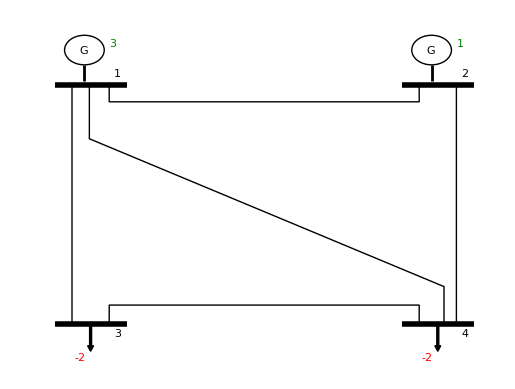

In [3]:
# inputs
# input admittances for the tranmission lines
admittances_input = {(1,2):1j*-10,(1,3):1j*-10,(1,4):1j*-10,(2,4):1j*-10,(3,4):1j*-10}
# power injections at each bus
pwr_inj = np.array([3,1,-2,-2])
branches_M = len(admittances_input)
nodes_N = len(pwr_inj)
# show the network
functions_4bus.create_fig_4bus(fig_inj=dict(enumerate(pwr_inj,start=1)))

## Build the Admittance Matrix

The Y-bus matrix is an 4x4 matrix of bus admittances. The shunt admittances equal zero in this example, so the terms $b_{1}$, $b_{2}$, $b_{3}$, and $b_{4}$ are set to zero.
\begin{equation}
Y = j\begin{bmatrix}
B_{11} & B_{12} & B_{13} & B_{14} \\
B_{21} & B_{22} & B_{23} & B_{24}  \\
B_{31} & B_{32} & B_{33} & B_{34}  \\
B_{14} & B_{24} & B_{34} & B_{44}  \\
\end{bmatrix}
\end{equation}
\begin{equation}
=j\begin{bmatrix}
b_{1}+b_{12}+b_{13}+b_{14} & -b_{12} & -b_{13} & -b_{14} \\
-b_{21} & b_{2}+b_{21}+b_{23}+b_{24} & -b_{23} & -b_{24}  \\
-b_{31} & -b_{32} & b_{3}+b_{31}+b_{32}+b_{34} & -b_{34}  \\
-b_{14} & -b_{24} & -b_{34} & b_{4}+b_{41}+b_{42}+b_{43}  \\
\end{bmatrix}
\end{equation}
\begin{equation}
=j\begin{bmatrix}
-30 & 10 & 10 & 10 \\
10 & -20 & 10 & 0 \\
10 & 10 & -30 & 10  \\
10& 0 & 10 & -20  \\
\end{bmatrix}
\end{equation}

In [5]:
# build the addmittance matrix
Admittance_matrix = np.zeros((nodes_N,nodes_N))
for i in range(nodes_N):
    for j in range(nodes_N):
        if i==j: 
            for k in range(len(admittances_input)):
                if (min(i+1,k+1),max(i+1,k+1)) in admittances_input:
                    Admittance_matrix[i,j] += np.imag(admittances_input[(min(i+1,k+1),max(i+1,k+1))])
        elif (min(i+1,j+1),max(i+1,j+1)) in admittances_input: Admittance_matrix[i,j] = -1*np.imag(admittances_input[(min(i+1,j+1),max(i+1,j+1))])           

## Get the B-prime Matrix

In [7]:
# Multiply the Amittances matrix by -1 (because shunt terms are zero we don't have to subtract them first)
B_matrix = -1*Admittance_matrix
# drop the first row and column- making bus 1 the reference bus
B_prime_matrix = B_matrix[1:,1:]
print(B_prime_matrix)

[[ 20.  -0. -10.]
 [ -0.  20. -10.]
 [-10. -10.  30.]]


## Find the Theta Values

We can use the DC power flow equation
\begin{equation*}
P = B^{'}\theta
\end{equation*}
and rearrange to solve for the voltage phase angles $\theta$:
\begin{equation*}
B^{'-1}P = B^{'-1}B^{'}\theta
\end{equation*}
\begin{equation*}
\theta = B^{'-1}P
\end{equation*}

In [9]:
theta = np.matmul(np.linalg.inv(B_prime_matrix),pwr_inj[1:])
theta

array([-0.0125, -0.1625, -0.125 ])

## Solve for Power Flows

Power flow from bus i to bus K can be solved using the Y-bus matrix and the theta values (phase angles):
\begin{equation*}
P_{ik} = B_{ik}(\theta_{i} - \theta_{k})
\end{equation*}

In [11]:
# solve for power flows- values are in p.u.
pwr_flows = {}
for i in admittances_input:
    if i[0]==1:
        pwr_flows[i[0],i[1]] = round(B_matrix[i[0]-1,i[1]-1]*theta[i[1]-2],3)  
    else: pwr_flows[i[0],i[1]] = round(B_matrix[i[0]-1,i[1]-1]*(theta[i[1]-2]-theta[i[0]-2]),3)
print(pwr_flows)

{(1, 2): 0.125, (1, 3): 1.625, (1, 4): 1.25, (2, 4): 1.125, (3, 4): -0.375}


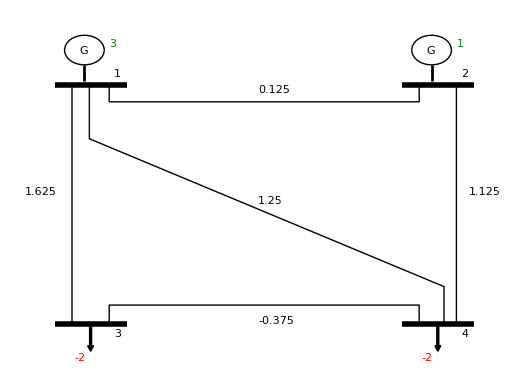

In [13]:
functions_4bus.create_fig_4bus(fig_pf = pwr_flows,fig_inj=dict(enumerate(pwr_inj,start=1)))
# flows are shown from lowered numbered bus to higher numbered bus
# so 0.125 on the line between buses 1 & 2 means 0.125 is flowing from bus 1 to 2
# and -0.375 on hte line between buses 3 and 4 means 0.375 is flowing from 4 to 3

## Power Transfer Distribution Factors (PTDFs)
PTDFs indicate the change in power flow on a branch in response to a 1 MW injection of power at one bus and 1 MW withdraw at another bus. Here we will have the injection at the slack bus (bus #1 in this exampe). 

See the lecture notes <a href="https://www.engineering.iastate.edu/~jdm/ee553/DCPowerFlowEquations.pdf">here</a> for details.

The vector containing the PTDFs can be calculated as follows:
\begin{equation*}
\textbf{PTDF} = \textbf{DA}[\textbf{B}']^{-1}\Delta \textbf{P}
\end{equation*}
where
$\textbf{D}$ is an MxM matrix that has the negative susceptances on the diagonal,

$\textbf{A}$ is an M x (N-1) node-arc incidence matrix with values 1 and -1 indicating which nodes are at the sending and receiving end of each branch, and

$\Delta \textbf{P}$ is a N-1 vector with all zeros except for a value 1 for the node with the incremental injection and -1 for the withdrawal

In [15]:
D = np.diag(-np.fromiter(admittances_input.values(),dtype=complex).imag)
A = np.zeros((branches_M,nodes_N))
for i,a in enumerate(admittances_input,start=1):
    A[i-1,a[0]-1] = 1
    A[i-1,a[1]-1] = -1
A = A[:,1:] # remove column 1 because it is the slack bus
dP = np.array([1,0,0])

In [17]:
PTDF = reduce(np.matmul,[D,A,np.linalg.inv(B_prime_matrix),dP])
print('PTDF values for +1 net injection at bus 3 and -1 net injection at bus 1:\n',PTDF)

PTDF values for +1 net injection at bus 3 and -1 net injection at bus 1:
 [-0.625 -0.125 -0.25   0.375 -0.125]
